# Functional Principal component analysis

In this notebook we compute the fpca scores of the compensators of the hospitalisation process

In [32]:
require(data.table)
require(ggplot2)
require(dplyr)
require(latex2exp)

options(repr.plot.width=6, repr.plot.height=5)

In [2]:
path = '/Users/davide/Documents/universita/tesi/src/fpca'
setwd(path)

In [3]:
# get cumulative Hazard and its mean
load('../../data/cumulative_hazards_hospitalisation.RData')
cumulative_hazard = data.table(cumulative_hazard)
mean_hazard = cumulative_hazard[,list('cumhaz' = mean(cumhaz)), by = 'time']

In [4]:
# reformat cumulative Hazard in a matrix format
cumulative_hazard_matrix = list()
patient_ids = unique(cumulative_hazard$id)
pb <- txtProgressBar(min = 0, max = length(patient_ids), style = 3)
for(i in 1:length(patient_ids)){
    setTxtProgressBar(pb, i)
    patient_id = patient_ids[i]
    cumulative_hazard_matrix[[patient_id]] = cumulative_hazard[id == patient_id,'cumhaz']
}
cumulative_hazard_matrix = bind_cols(cumulative_hazard_matrix)
colnames(cumulative_hazard_matrix) = as.character(patient_ids)

  |======================================================================| 100%

In [5]:
# number of rows: time
# number of columns: number of patients
dim(cumulative_hazard_matrix)

[1]  366 4541

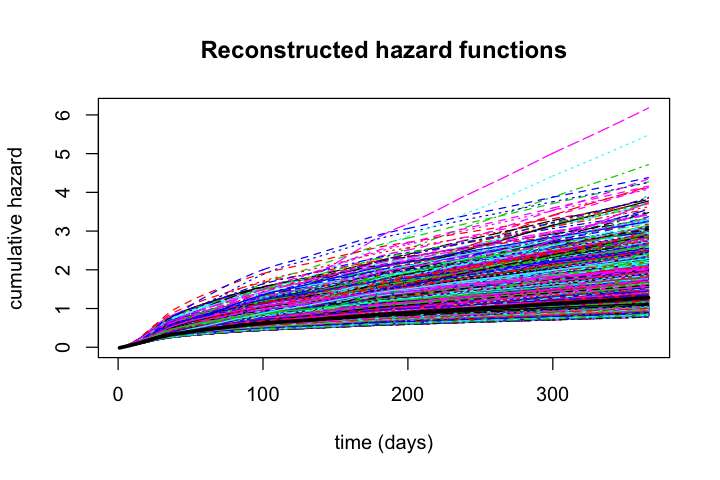

In [6]:
nc <- dim(cumulative_hazard_matrix)[2]
m <- dim(cumulative_hazard_matrix)[1]
h <- 1

# Functional data considered in FPCA.
matplot(cumulative_hazard_matrix,type="l",xlab="time (days)",ylab="cumulative hazard",main="Reconstructed hazard functions")
mu <- apply(cumulative_hazard_matrix,MARGIN=1,"mean")
points(mean_hazard$cumhaz ,type="l", lwd=3)

In [7]:
# Eigenvalues and eigenfunctions
pca <- prcomp(t(cumulative_hazard_matrix))
efuncs <- pca$rotation*sqrt(1/h)
evalues <- pca$sdev^2*h

,component 1,component 2
eigenvalue,34.37565,0.6965348
% variance,97.75832,1.9808232
cumulated % variance,97.75832,99.7391459


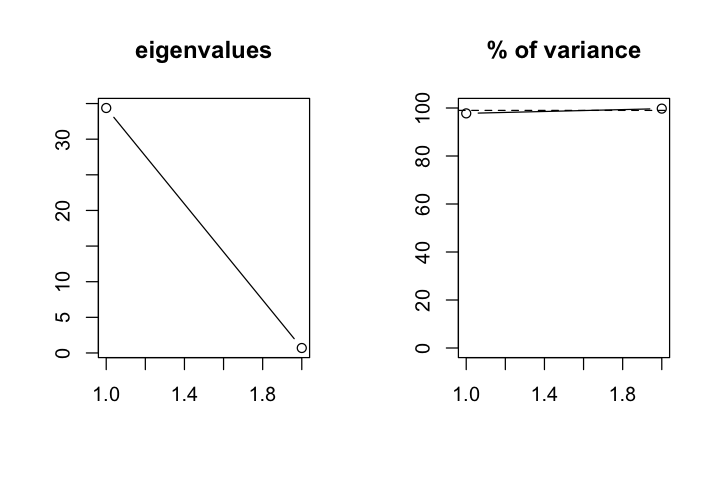

In [8]:
# Principal components diagnostics

# Eigenvalues
sum.evalues <- sum(evalues)
percent.var <- evalues/sum.evalues
# Choose the minimum K1 such that the sum of eigenvalues (variances) is at least 99% of total
K <- min(which(cumsum(percent.var)>=0.99))
# Summary table
evtable <- rbind(evalues[1:K], 100*evalues[1:K]/sum.evalues, 100*cumsum(evalues[1:K])/sum.evalues)
rownames(evtable) <- c("eigenvalue", "% variance", "cumulated % variance")
colnames(evtable) <- paste("component",1:K)
evtable

# Scree plots:
par(mfrow=c(1,2))
plot(evalues[1:K], xlab="", ylab="", main="eigenvalues" ,type="b")
plot(evtable[3,],xlab="",ylab="",main="% of variance",type="b",ylim=c(0,100))
abline(99,0,lty=2)

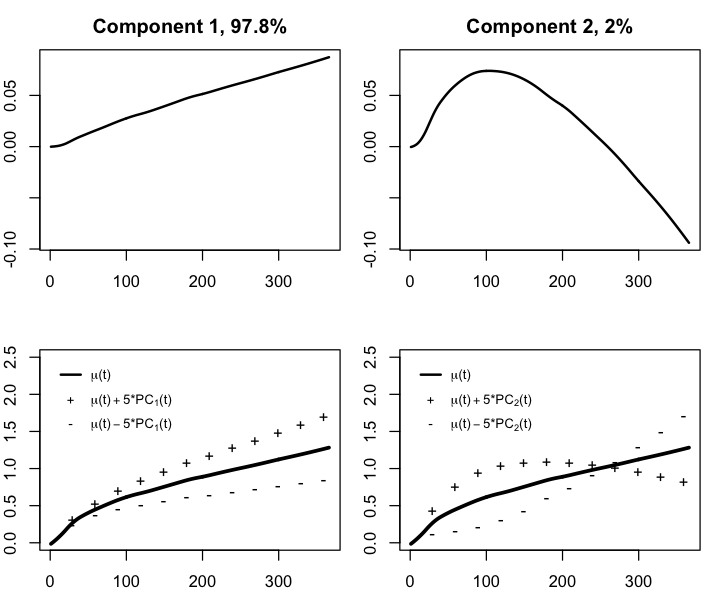

In [33]:
# Eigenfunctions
# Sign chosen to have positive integral, for ease of interpretation
for(i in 1:K) {
  tempfun <- efuncs[,i]
  tempsign <- sum(tempfun)
  efuncs[,i] <- ifelse(tempsign<0, -1,1) * tempfun
}

time = 0:366
# Plot of first k eigenfunctions
k=K
par(mfcol=c(2,k),mar=c(2.5,2,2.5,1))
ylim <- range(efuncs[,1:k])
ylim2 <- c(0,2.5)
for(i in 1:k) {
  v1 <- efuncs[,i]
  plot(v1, type="l", ylab="", xlab="time (days)", ylim=ylim, lwd=2, main=paste("Component ", i,", ",100*round(percent.var[i],3), "%", sep=""))
  text(2,-0.95, "time (days)")
  #v2 <- v1 * sqrt(evalues[i])
  v2 <- v1 * 5
  widep <- ((1:m)%%30)==0
  plot(mu, type="l", ylim=ylim2, lwd=3)
  points(time[widep],mean_hazard$cumhaz[widep] + v2[widep], lwd=3, pch="+")
  points(time[widep],mean_hazard$cumhaz[widep] - v2[widep], lwd=3, pch="-")
    
  legend(10,2.5, # where
         legend=c(TeX('$\\mu(t)$'),TeX(paste('$\\mu(t) + ','5*PC_',i,'(t)$',sep = '')),TeX(paste('$\\mu(t) - ','5*PC_',i,'(t)$',sep = ''))), # text
         lty=c(1,NA,NA), lwd = c(2,1,1), pch = c(NA,'+','-'), # symbols
         cex=0.8,y.intersp=2.5,box.lty=0 # other options
        )
}

In [10]:
# Scores on the first K principal components
score <- NULL
for(i in 1:K){
  score <- cbind(score,(as.matrix(t(cumulative_hazard_matrix-mean_hazard$cumhaz)) %*% cbind(efuncs[,i]))*h)
}

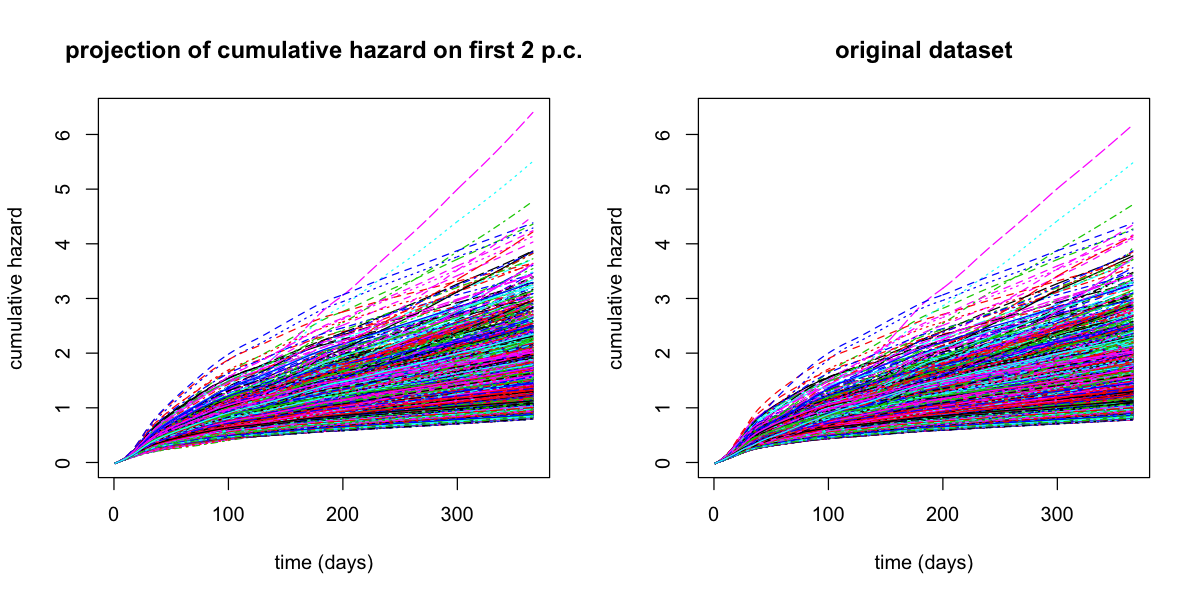

In [11]:
options(repr.plot.width=10, repr.plot.height=5)

# Projection on first 2 P.C.
score1 <- score[,1]
score2 <- score[,2]
proj1 <- apply(X=cbind(score1),FUN=`*`,MARGIN=1,y=efuncs[,1]) + apply(X=cbind(score2),FUN=`*`,MARGIN=1,y=efuncs[,2])+mu
layout(cbind(1,2))
ylim=range(c(range(cumulative_hazard_matrix),range(proj1)))
matplot(proj1, type="l",xlab="time (days)", ylab="cumulative hazard", main=paste("projection of cumulative hazard on first 2 p.c.", sep=" "), ylim=ylim)
matplot(cumulative_hazard_matrix, type="l", xlab="time (days)", ylab="cumulative hazard", main="original dataset", ylim=ylim)

In [12]:
# reformat score fpca
patients = rownames(score)
rownames(score) = NULL
colnames(score) = c('PC1','PC2')
score = data.table('id'=patients,score)

head(score)

id,PC1,PC2
10000243,11.7766373,2.7808122
10000471,7.5054363,-0.5748265
10000717,1.4768682,0.3687805
10003004,-4.2522032,-0.2800180
10006065,0.4320898,0.1475507
10007000,2.7059192,-0.5461010


In [13]:
score_hospitalisation = score
save(score_hospitalisation,file = '../../data/score_fpca_hospitalisation.RData')